In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [63]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
sigma2 = 0.2 # Realized vol of the path (greater than vol used in BS price - we underestimate)
q = 0
T = 20/52 #20/52
K = 50
type = 'c'

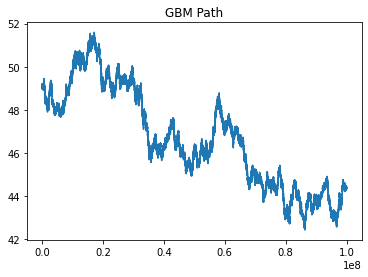

In [64]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
#np.random.seed(seed=1)
M = 10000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma2*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [65]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)
option_value_array = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type)*option_exposure

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)*np.exp(-q*T)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma*np.exp(-q*T)/(2*np.sqrt(T)) + q*S*norm.cdf(d1)*np.exp(-q*T)


The time of execution of is: 32.862529039382935
Option price is [2.40052732 2.40075174 2.40089507 ... 0.         0.         0.        ]


In [66]:
summary_df = pd.DataFrame(list(zip(S, option_value_array, delta_array)), columns=['Stock_Price', 'Option_Value', 'Delta'])
summary_df

,Stock_Price,Option_Value,Delta
0,49.000000,-240052.732327,0.521605
1,49.000430,-240075.174494,0.521633
2,49.000705,-240089.506754,0.521651
3,49.001135,-240111.957534,0.521679
4,49.000502,-240078.902228,0.521638
...,...,...,...
99999995,44.418617,-0.000000,0.000000
99999996,44.418449,-0.000000,0.000000
99999997,44.417730,-0.000000,0.000000
99999998,44.418052,-0.000000,0.000000


In [67]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Share_PnL'] = summary_df['Shares_Held'].shift()*(summary_df['Stock_Price'] - summary_df['Stock_Price'].shift())

summary_df['Interest_Cost'] = (summary_df['Shares_Held']*summary_df['Stock_Price']).shift()*r*dt + summary_df['Option_Value'].shift()*r*dt
summary_df['Option_PnL'] = summary_df['Option_Value'] - summary_df['Option_Value'].shift()
summary_df['Portfolio_PnL'] = summary_df['Share_PnL'] - summary_df['Interest_Cost'] 
summary_df['Hedged_Portfolio_PnL'] = summary_df['Portfolio_PnL'] + summary_df['Option_PnL'] 

summary_df['Portfolio_Value'] = -summary_df['Option_Value']
for i in range(1, len(summary_df)):
    summary_df['Portfolio_Value'].iloc[i] = summary_df['Portfolio_Value'].iloc[i-1] + summary_df['Share_PnL'].iloc[i] + (summary_df['Portfolio_Value'].iloc[i-1] - summary_df['Shares_Held'].iloc[i-1]*summary_df['Stock_Price'].iloc[i-1])*r*dt 
summary_df['Portfolio_PnL2'] = summary_df['Portfolio_Value'] - summary_df['Portfolio_Value'].shift()
summary_df['Hedged_Portfolio_PnL2'] = summary_df['Portfolio_PnL2'] + summary_df['Option_PnL'] 

summary_df

c:\Users\Matthew\anaconda3\envs\myenv3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


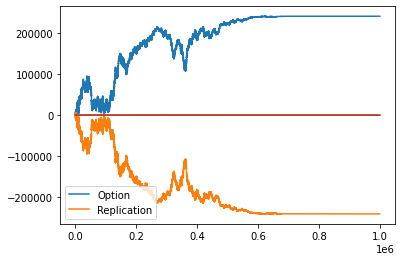

In [ ]:
plt.plot(summary_df['Option_PnL'].cumsum(), label='Option')
plt.plot(summary_df['Portfolio_PnL'].cumsum(), label='Replication')
plt.plot(summary_df['Hedged_Portfolio_PnL'].cumsum())
plt.plot(summary_df['Hedged_Portfolio_PnL2'].cumsum())

plt.legend()
plt.show()

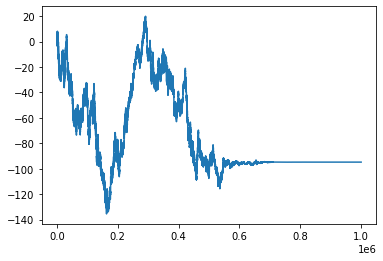

In [ ]:
plt.plot(summary_df['Hedged_Portfolio_PnL'].cumsum())


In [ ]:
hedging_pnl = summary_df['Portfolio_PnL'].cumsum().iloc[-1] + summary_df['Option_PnL'].cumsum().iloc[-1]
print(f'Hedging Error: ${hedging_pnl}')


Hedging Error: $-94.79128590086475


In [ ]:
hedging_pnl = summary_df['Portfolio_PnL2'].cumsum().iloc[-1] + summary_df['Option_PnL'].cumsum().iloc[-1]
print(f'Hedging Error2: ${hedging_pnl}')

Hedging Error2: $-96.236523661908
